Notebook for testing the TETRAQUAD module

In [10]:
import tetraquad
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.001
N = 20
#grid, weights = tetraquad.old2_unit_quadrature(alpha, N)
grid, weights = tetraquad.unit_quadrature_nnls(alpha, N, include_endpoints=False)
weights = weights.flatten()


#np.save("grid_N10.npy", grid)
#np.save("weights_N10.npy", weights)

M = 27 , N = 20
785 825
NNLS complete, rnorm 3.464158211496959e-05


In [2]:
grid2, weights2 = tetraquad.uniform_tetrapyd_weights(alpha, N, MC_N_SAMPLES=1000000)

In [13]:
#np.save("grid_N50_nnlm.npy", grid)
#np.save("weights_N50_nnlm.npy", weights)

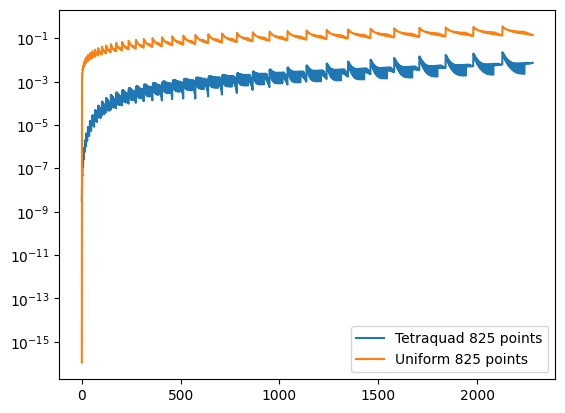

In [11]:
# Test to check numerical integration accuracy

k1, k2, k3 = grid
ps, qs, rs = tetraquad.poly_triplets_total_degree(2*N)
#ps, qs, rs = tetraquad.poly_triplets_total_degree_ns(N)
#ps = ps + 0.966-1
#qs = qs + 0.966-1
#rs = rs + 0.966-1

analytic = tetraquad.analytic_poly_integrals_alpha(ps, qs, rs, alpha)
numerical = np.array([np.dot(weights, tetraquad.poly_evaluations(p, q, r, k1, k2, k3)) for p, q, r in zip(ps, qs, rs)])
numerical2 = np.array([np.dot(weights2, tetraquad.poly_evaluations(p, q, r, grid2[0,:], grid2[1,:], grid2[2,:])) for p, q, r in zip(ps, qs, rs)])

error = (numerical - analytic) / analytic
error2 = (numerical2 - analytic) / analytic
#plt.plot(error, label="Tetraquad {} points".format(grid.shape[1]))
#plt.plot(error2, label="Uniform {} points".format(grid2.shape[1]))
plt.plot(np.abs(error), label="Tetraquad {} points".format(grid.shape[1]))
plt.plot(np.abs(error2), label="Uniform {} points".format(grid2.shape[1]))
plt.yscale('log')
plt.legend()

/Users/wuhyun/Fawcett/Tetraquad/tetraquad.py:524: RuntimeWarning: divide by zero encountered in divide
  fact =  1 / (4 * omegas ** 3)
/Users/wuhyun/Fawcett/Tetraquad/tetraquad.py:529: RuntimeWarning: invalid value encountered in multiply
  evals *= fact


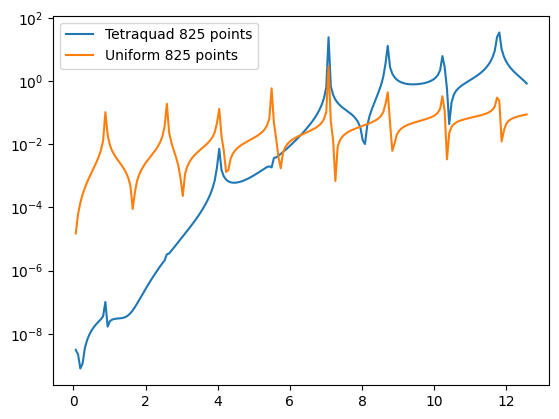

In [12]:
# Test to check numerical integration accuracy for sinusoidal shapes

k1, k2, k3 = grid
omegas = 2 * np.pi * np.linspace(0, 0.1*N, 10*N)
phis = np.zeros_like(omegas) + np.pi/2
#phis = np.linspace(0, np.pi, N+1)
#omegas = 0.5 * np.ones_like(phis)

analytic = tetraquad.analytic_sine_integrals(omegas, phis, alpha)
numerical = np.array([np.dot(weights, tetraquad.sine_evaluations(omega, phi, grid[0,:], grid[1,:], grid[2,:])) for omega, phi in zip(omegas, phis)])
numerical2 = np.array([np.dot(weights2, tetraquad.sine_evaluations(omega, phi, grid2[0,:], grid2[1,:], grid2[2,:])) for omega, phi in zip(omegas, phis)])

error = (numerical - analytic) / analytic
error2 = (numerical2 - analytic) / analytic
#plt.plot(omegas, error, label="Tetraquad {} points".format(grid.shape[1]))
#plt.plot(omegas, error2, label="Uniform {} points".format(grid2.shape[1]))
#plt.plot(omegas, numerical, "k")
#plt.plot(omegas, numerical2, "b")
#plt.plot(omegas, analytic, "r")

plt.plot(omegas, np.abs(error), label="Tetraquad {} points".format(grid.shape[1]))
plt.plot(omegas, np.abs(error2), label="Uniform {} points".format(grid2.shape[1]))
plt.yscale("log")

#plt.plot(phis, numerical, "k")
#plt.plot(phis, numerical2, "b")
#plt.plot(phis, analytic, "r")
plt.legend()

/Users/wuhyun/Fawcett/Tetraquad/tetraquad.py:462: RuntimeWarning: invalid value encountered in power
  I_x += a**(p+q+r+3) * ((-1)**q * B(2, 1/a, p+2, q+1) + (-1)**r * B(2, 1/a, p+2, r+1)) / ((p+1.) * (p+q+r+3.))
/Users/wuhyun/Fawcett/Tetraquad/tetraquad.py:418: RuntimeWarning: invalid value encountered in subtract
  return incomplete_beta(x2, a, b) - incomplete_beta(x1, a, b)
/Users/wuhyun/Fawcett/Tetraquad/tetraquad.py:467: RuntimeWarning: invalid value encountered in power
  I_y += a**(p+q+r+3) * ((-1)**r * B(2, 1/a, q+2, r+1) + (-1)**p * B(2, 1/a, q+2, p+1)) / ((q+1.) * (p+q+r+3.))


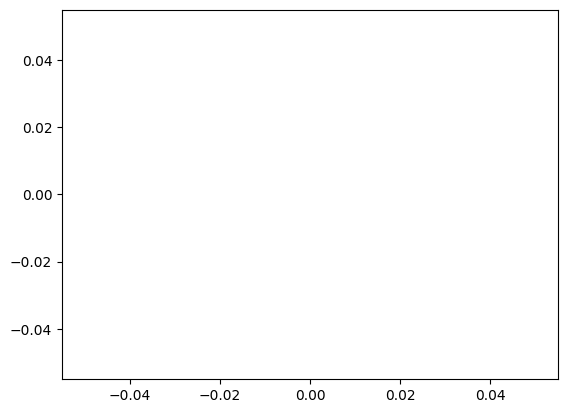

In [ ]:
# Test to check numerical integration accuracy for inverse modes

k1, k2, k3 = grid
ps, qs = tetraquad.poly_pairs_total_degree(N)
#ps, qs, rs = tetraquad.poly_triplets_total_degree_ns(N)
ps, qs = ps[ps+qs >= 2], qs[ps+qs >= 2]
rs = - (2 - 0.966) * np.ones_like(ps)

analytic = tetraquad.analytic_poly_integrals_alpha(ps, qs, rs, alpha)
#analytic = tetraquad.analytic_poly_integrals(ps, qs, rs)
numerical = np.array([np.dot(weights, tetraquad.poly_evaluations(p, q, r, k1, k2, k3)) for p, q, r in zip(ps, qs, rs)])
numerical2 = np.array([np.dot(weights2, tetraquad.poly_evaluations(p, q, r, grid2[0,:], grid2[1,:], grid2[2,:])) for p, q, r in zip(ps, qs, rs)])

error = (numerical - analytic) / analytic
error2 = (numerical2 - analytic) / analytic
plt.plot(error)
#plt.plot(error2, 'k')

In [6]:
#t1 = tetraquad.analytic_poly_integrals(- 0.96 * np.ones_like(ps), qs, rs, alpha)
#tn1 = np.array([np.dot(weights, tetraquad.poly_evaluations(-0.96, q, r, k1, k2, k3)) for q, r in zip(qs, rs)])

e1 = (tn1 - t1) / t1
print(np.max(np.abs(e1)))
plt.plot(e1)

NameError: name 'p' is not defined

5.237888697068019e-06


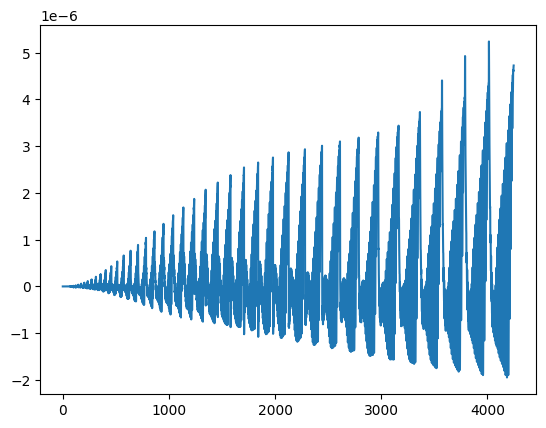

In [17]:
#plt.plot(analytic)
#plt.plot(numeric)
#plt.plot(analytic/numeric)
plt.plot(error)
#plt.plot(error2, 'r')
print(np.max(np.abs(error)))
#print(np.max(np.abs(error2)))
#plt.xlim([0,10])
#print(error[0], error2[0])
#plt.plot((analytic/numeric)[:67])
#print((analytic/numeric)[:67])

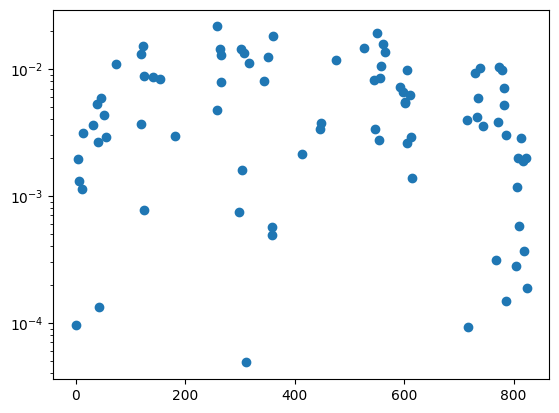

In [13]:
plt.plot(weights, "o")
plt.yscale("log")

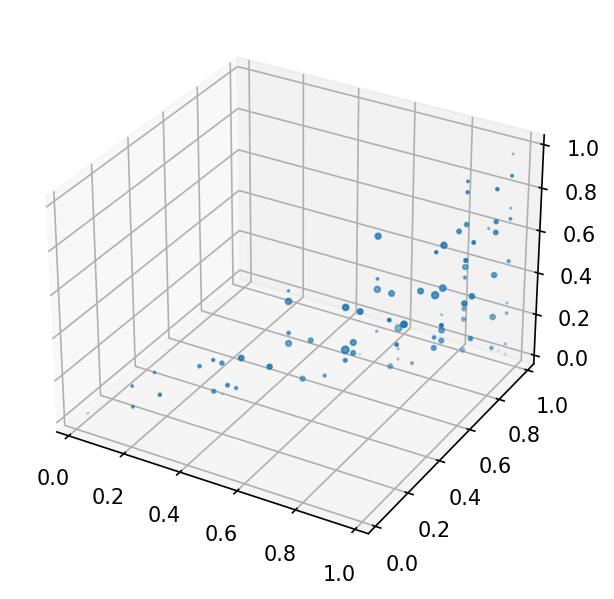

In [14]:
%matplotlib inline
s = weights * 500
xs, ys, zs = grid
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, s=s)
plt.show()

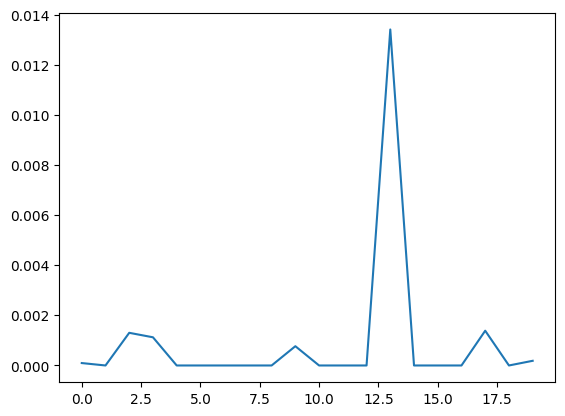

In [15]:
plt.plot(weights[(xs == ys) & (ys == zs)])

(array([733.,   4.,  12.,   4.,   5.,   2.,   5.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   4.,   1.,   2.,   2.,   0.,   2.,   2.,   0.,
          1.,   2.,   0.,   3.,   2.,   3.,   0.,   3.,   1.,   0.,   0.,
          2.,   1.,   0.,   1.,   1.,   1.,   0.,   2.,   0.,   2.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.        , 0.00029573, 0.00059145, 0.00088718, 0.0011829 ,
        0.00147863, 0.00177436, 0.00207008, 0.00236581, 0.00266154,
        0.00295726, 0.00325299, 0.00354871, 0.00384444, 0.00414017,
        0.00443589, 0.00473162, 0.00502734, 0.00532307, 0.0056188 ,
        0.00591452, 0.00621025, 0.00650597, 0.

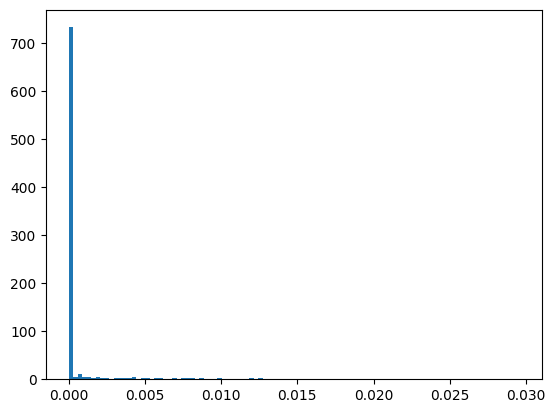

In [9]:
#weights.flatten()
plt.hist(weights, bins=100)